# Pronostic de pannes sur des données IoT

Pronostic de pannes à partir du jeu de données généré par https://github.com/Azure/AI-PredictiveMaintenance/blob/master/src/Notebooks/DataGeneration.ipynb. Proposition de solution à base de machine learning avec un objectif de niveau de confiance élevé.

# 1. Traitement des données

In [1]:
# Affichage plus large du notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# Importations de modules et classes
import sys, random, pickle
print("Python: ", sys.version)
import numpy as np
print("NumPy: ", np.__version__)
import joblib
print("Joblib: ", joblib.__version__)
import pandas as pd
print("Pandas: ", pd.__version__)
import sklearn as sk
print("Scikit-learn: ", sk.__version__)

from typing import List, Set, Tuple
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

# Matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib: ", matplotlib.__version__)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Python:  3.7.6 (default, Jan 19 2020, 22:34:52) 
[GCC 9.2.1 20200117]
NumPy:  1.18.1
Joblib:  0.14.1
Pandas:  1.0.1
Scikit-learn:  0.22.1
Matplotlib:  3.1.3


# Importation des données

L'exécution du notebook DataGeneration.ipynb génère un jeu de données (télémétrie et maintenance) dans le dossier `~/data`. La fonction `load_data` charge ces données dans deux DataFrames: `tele` et `logs`.

In [3]:
data_path = Path.home().joinpath('data')
data_dir = str(data_path)
%ls $data_dir
# %ls $data_dir/logs -lh
# %ls $data_dir/telemetry -lh

logs/  telemetry/


In [4]:
def load_data(d_path: Path = data_path) -> (pd.DataFrame, pd.DataFrame):
    """Retourne le couple (logs, tele) où le second est une concaténation
    de l'ensemble des fichiers parquet présents dans le répertoire d_path/telemetry.
    """
    return pd.read_parquet(d_path.joinpath('logs/logs.parquet'), engine='fastparquet'), pd.concat(
        pd.read_parquet(parquet_file, engine='fastparquet')
        for parquet_file in d_path.glob('telemetry/*.parquet'))

In [5]:
%%time
logs, tele = load_data()
#display(tele.head(1))
#display(tele.head(1))

CPU times: user 9.2 s, sys: 751 ms, total: 9.95 s
Wall time: 10.9 s


# Prétraitement des données

* suppression des colonnes inutiles
* normalisation des données de télémétrie dans [0, 1]
* conversion des textes en int et float
* création d'une liste "parc des machines"
* prise en compte des "secondes écoulées où la machine est en fonctionnement" (`seconds_ON`)
* lissage des données de télémétrie (prise en compte des temps OFF et des périodes d'allumages)

In [6]:
# Nombre de machines
n_machines = len(tele["machineID"].unique())
# n_machines

In [7]:
def trim_tele(tele: pd.DataFrame = tele) -> pd.DataFrame:
    "Enlève les colonnes 'ambient_temperature' et 'ambient_pressure'"
    return tele.drop(["ambient_temperature", "ambient_pressure"], axis=1)

def trim_logs(logs: pd.DataFrame = logs) -> pd.DataFrame:
    "Enlève la colonne 'level'"
    return logs.drop("level", axis=1)

In [8]:
%%time
tele_trim = trim_tele(tele)
logs_trim = trim_logs(logs)
#display(tele_trim.head(1))
#display(logs_trim.head(1))

CPU times: user 147 ms, sys: 28.4 ms, total: 176 ms
Wall time: 175 ms


In [9]:
def normalize_tele(tele_trim: pd.DataFrame = tele_trim) -> pd.DataFrame:
    "Retourne un pd.DataFrame de télémétrie avec des données ramenées entre 0 et 1."
    df = tele_trim.copy()
    # Mise à zéro des vitesses négatives, qui sont des artefacts venant du bruit.
    df.loc[df['speed'] < 0, 'speed'] = 0
    df[['speed', 'temperature', 'pressure']] = minmax_scale(df[['speed', 'temperature', 'pressure']])
    return df

In [10]:
%%time
tele_norm = normalize_tele(tele_trim)
#display(tele_norm.head(1))

CPU times: user 3.02 s, sys: 448 ms, total: 3.47 s
Wall time: 3.49 s


In [11]:
# Il y a probablement une fonction prédéfinie pour cela.
# L'argument est un TimedeltaIndex, car convertir en secondes un DatetimeIndex n'a pas vraiment de sens.
def timedeltaIndex_to_seconds(t: pd.TimedeltaIndex) -> int:
    "Retourne le nombre de secondes correspondant au timedeltaIndex donné."
    return t.days * 3600 * 24 + t.seconds

def machineID_to_int(ID: str) -> int:
    "Retourne l'entier xxxx si le machineID est 'M_xxxx'."
    assert ID[:2] == 'M_'
    return int(ID[2:])

def code_to_int(code: str) -> int:
    "Retourne l'entier x si le code est 'Fx' ou 0 si le code est 'fixed'."
    return {"fixed": 0, "F1": 1, "F2": 2}[code]

def data_to_int(tele: pd.DataFrame = tele_norm, logs: pd.DataFrame = logs_trim) -> [pd.DataFrame, pd.DataFrame]:
    """Retourne une liste de deux pd.DataFrames [tele, logs], constitués uniquement
    de int ou float et indexés par le nombre de secondes écoulées depuis la première mesure.
    Ne modifie pas les arguments.
    """
    df = [tele_norm.copy(), logs_trim.copy()]
    first = df[0].index.min() # premier instant
    for i in range(2):
        df[i]["machineID"] = df[i]["machineID"].apply(machineID_to_int)
        df[i]["seconds"] = timedeltaIndex_to_seconds(df[i].index - first)
    df[0].set_index("seconds", inplace=True)
    df[1].reset_index(inplace=True)
    df[1].drop('timestamp', axis=1, inplace=True)
    df[1]["code"] = df[1]["code"].apply(code_to_int)
    return df

In [12]:
%%time
tele_int, logs_int = data_to_int(tele_norm, logs_trim)
#display(tele_int.head(1))
#display(logs_int.head(1))

CPU times: user 5.86 s, sys: 199 ms, total: 6.06 s
Wall time: 6.12 s


In [13]:
def tombe_panne(logs: pd.DataFrame = logs_int) -> [Set[int], Set[int]]:
    """Renvoie une liste de deux ensembles: machines ayant connu une panne
    de code F1 ou F2 respectivement.
    """
    s = [set([]) for _ in range(2)]
    for i in logs.itertuples():
        if i.code != 0:
            s[i.code - 1].add(i.machineID)
    return s

In [14]:
mac_panne = tombe_panne(logs_int)
#print(mac_panne)
#mac_panne[0] & mac_panne[1]

In [15]:
def creer_parc(tele_int: pd.DataFrame = tele_int) -> pd.DataFrame:
    """Retourne le parc des machines, qui est une liste de pd.DataFrames indicés
    par secondes et triés chronologiquement.
    """
    n_machines = len(tele_int["machineID"].unique())
    return [tele_int[tele_int["machineID"] == i].sort_index() for i in range(n_machines)]

In [16]:
%%time
# Création du parc de machines:
parc = creer_parc(tele_int)
#display(parc[0].head(1))

CPU times: user 9.97 s, sys: 15.1 ms, total: 9.99 s
Wall time: 9.99 s


In [17]:
def lissage(tele_mac: pd.DataFrame, delai_liss: int = 10, delai_init: int = 20) -> pd.DataFrame:
    """On retire les lignes correspondant à une machine à l'arrêt, et puisqu'il y
    a un certain délai après chaque allumage pour atteindre un régime à peu près
    stationnaire, on lisse les courbes correspondantes.
    La température n'a pas besoin d'être lissée.
    """
    df = tele_mac.copy()
    # Ajout du minimum des vitesses désirées sur les `delai_liss` dernières secondes:
    df["min_speed_desired"] = pd.concat([df["speed_desired"].shift(periods=i) for i in range(delai_liss+1)], axis=1).min(axis=1)
    # Suppression des premières lignes car la température n'a pas atteint un niveau représentatif
    df = df[delai_init:]
    # Suppression des lignes où la machine est éteinte:
    df.drop(df[df["speed_desired"] == 0].index, inplace=True)
    # Remplacement des données durant l'allumage par np.nan:
    df["speed"] = df["speed"].where(df["min_speed_desired"] == 1000, other=np.nan)
    df["pressure"] = df["pressure"].where(df["min_speed_desired"] == 1000, other=np.nan)
    df.drop(["speed_desired", "min_speed_desired"], axis=1, inplace=True)
    # Remplacement des conditions pendant les périodes d'allumage:
    df.fillna(axis=0, method="ffill", inplace=True)
    # Réindexage: l'index n'est plus "seconds" (nombre de secondes écoulées depuis la première donnée
    # de l'ensemble du parc) mais un nouvel index correspondant au nombre de secondes écoulées où la
    # machine donnée est en fonctionnement; l'ancien index "seconds" et gardé dans une nouvelle colonne:
    df.reset_index(inplace=True)
    df.index.name="seconds_ON"
    return df

In [18]:
%%time
# Création du parc lissé:
parc_lisse = [lissage(tele_mac, delai_liss=10, delai_init=20) for tele_mac in parc]
#display(parc_lisse[0].head(1))

CPU times: user 8.32 s, sys: 884 ms, total: 9.2 s
Wall time: 9.2 s


# Visualisation

* visualisation du lissage
* graphe pour une machine donnée tout au long de la période, et visualisation des deux types de panne bien distincts

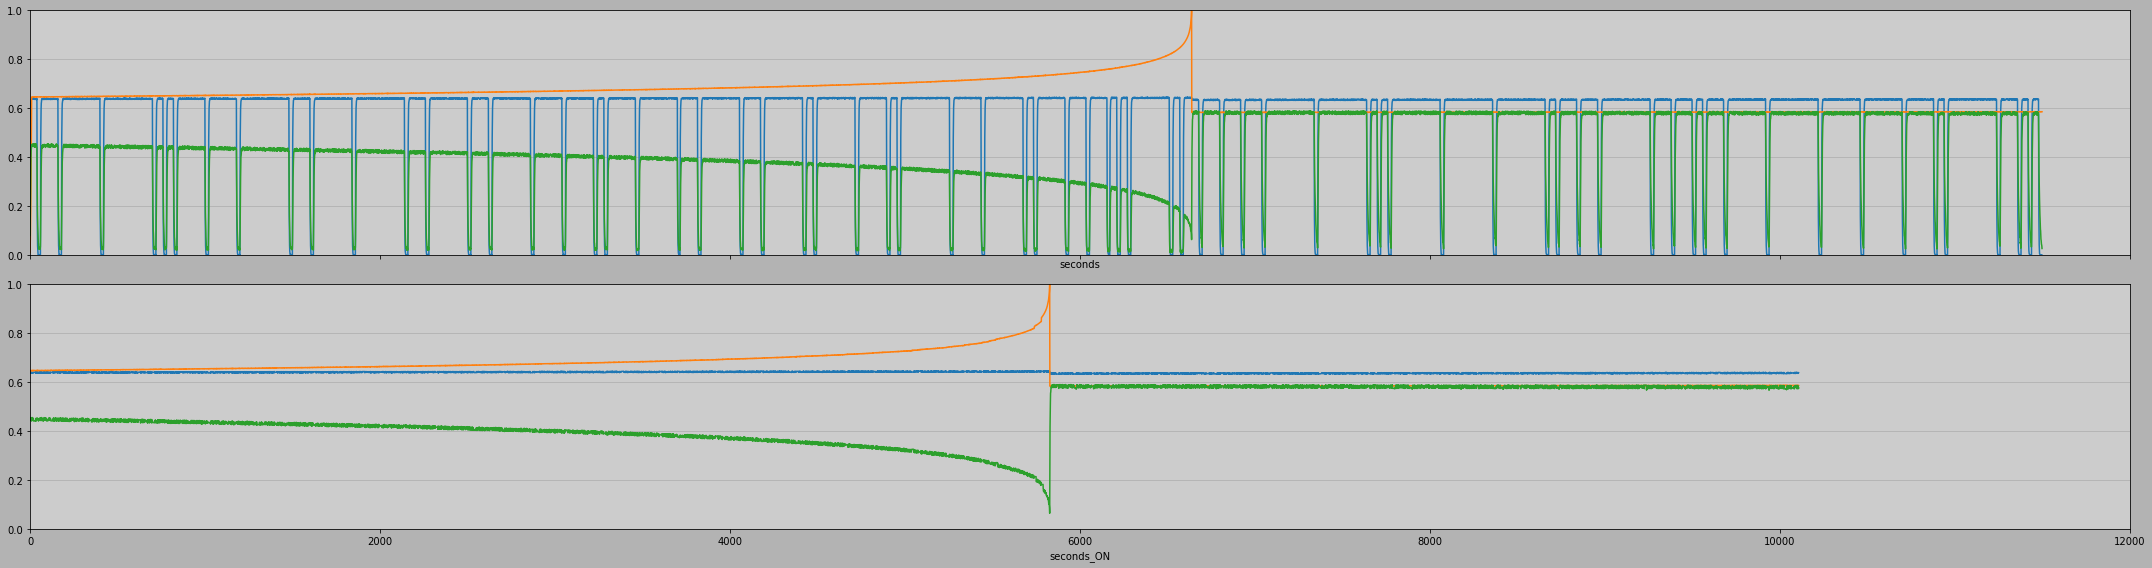

In [19]:
# Démonstration du lissage
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 8))
ax0.plot(parc[1].reset_index()[["speed", "temperature", "pressure"]])
ax1.plot(parc_lisse[1][["speed", "temperature", "pressure"]])
ax0.set_xlim([0, 12_000])
ax0.set_ylim([0, 1])
ax0.grid(axis='y')
ax1.grid(axis='y')
ax0.set_xlabel("seconds")
ax1.set_xlabel("seconds_ON")
ax0.set_facecolor("0.8")
ax1.set_facecolor("0.8")
fig.set_facecolor("0.7")
plt.tight_layout()
plt.show()

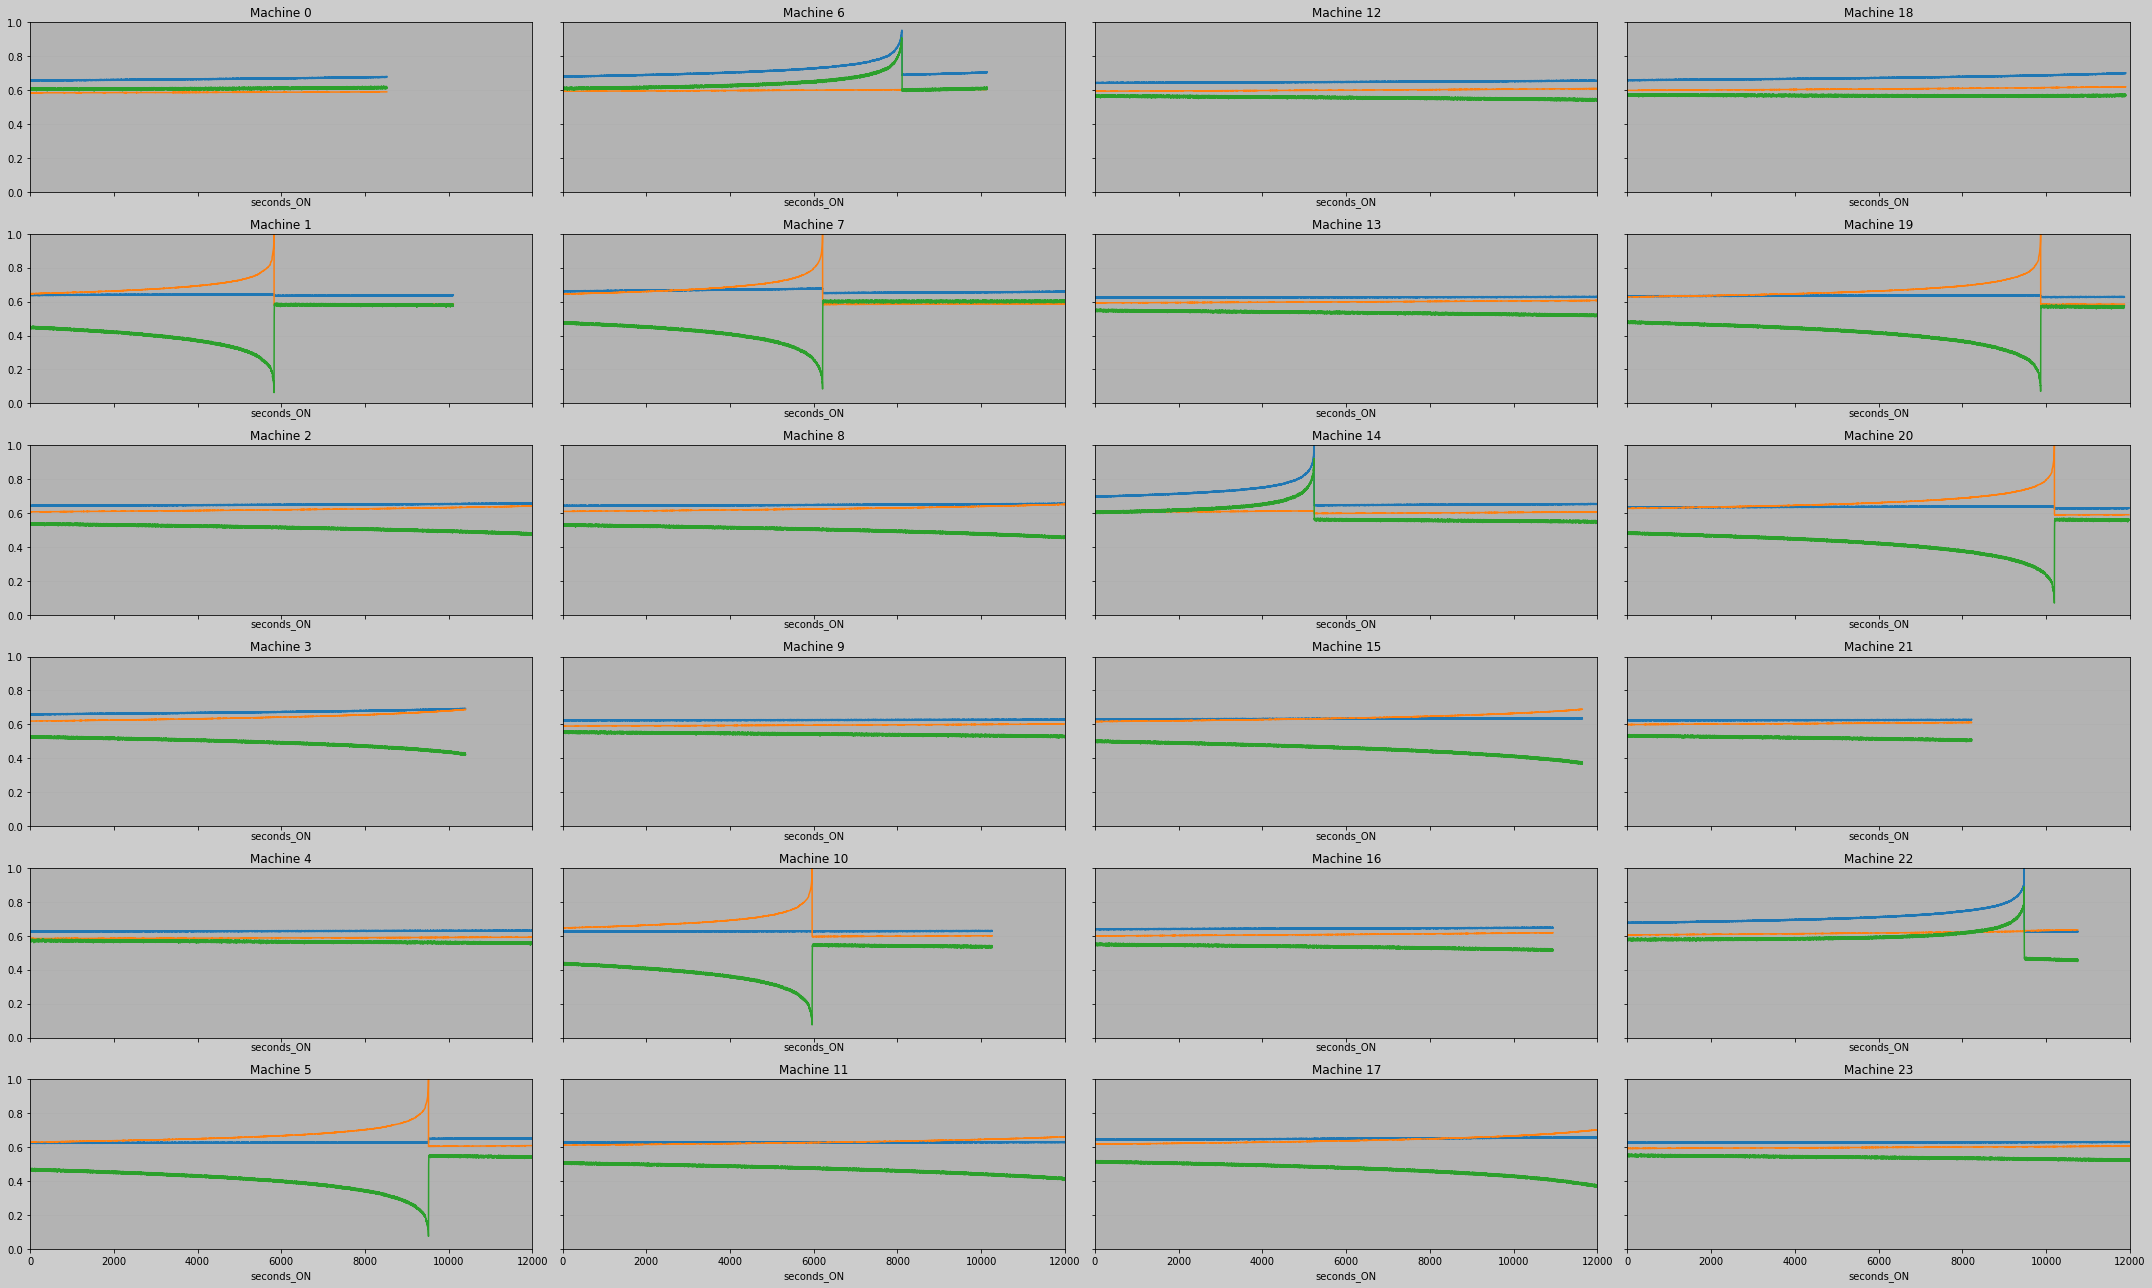

In [20]:
# Affichage des n premières machines sur col colonnes
n = 24
col = 4
m = 1 + (n - 1) // col
fig, axs = plt.subplots(m, col, sharex=True, sharey=True, figsize=(30, n * 3 / col))
#fig.suptitle('Vitesse, température et pression de différentes machines', fontsize=16)
# fig.figsize=(20, 15)
for i in range(n):
    j = (i % m, i // m)
    #ax = plt.gca()
    df = parc_lisse[i].reset_index(inplace=False)
    axs[j].plot(df[["speed", "temperature", "pressure"]])
    axs[j].set_title('Machine '+str(i))
    axs[j].set_xlabel("seconds_ON")
    axs[j].set_xlim([0, 12_000])
    axs[j].set_ylim([0, 1])
    axs[j].grid(axis='y')
    axs[j].figsize=(20, 5)
    axs[j].set_facecolor("0.7")
fig.set_facecolor("0.8")
plt.tight_layout()
plt.show()

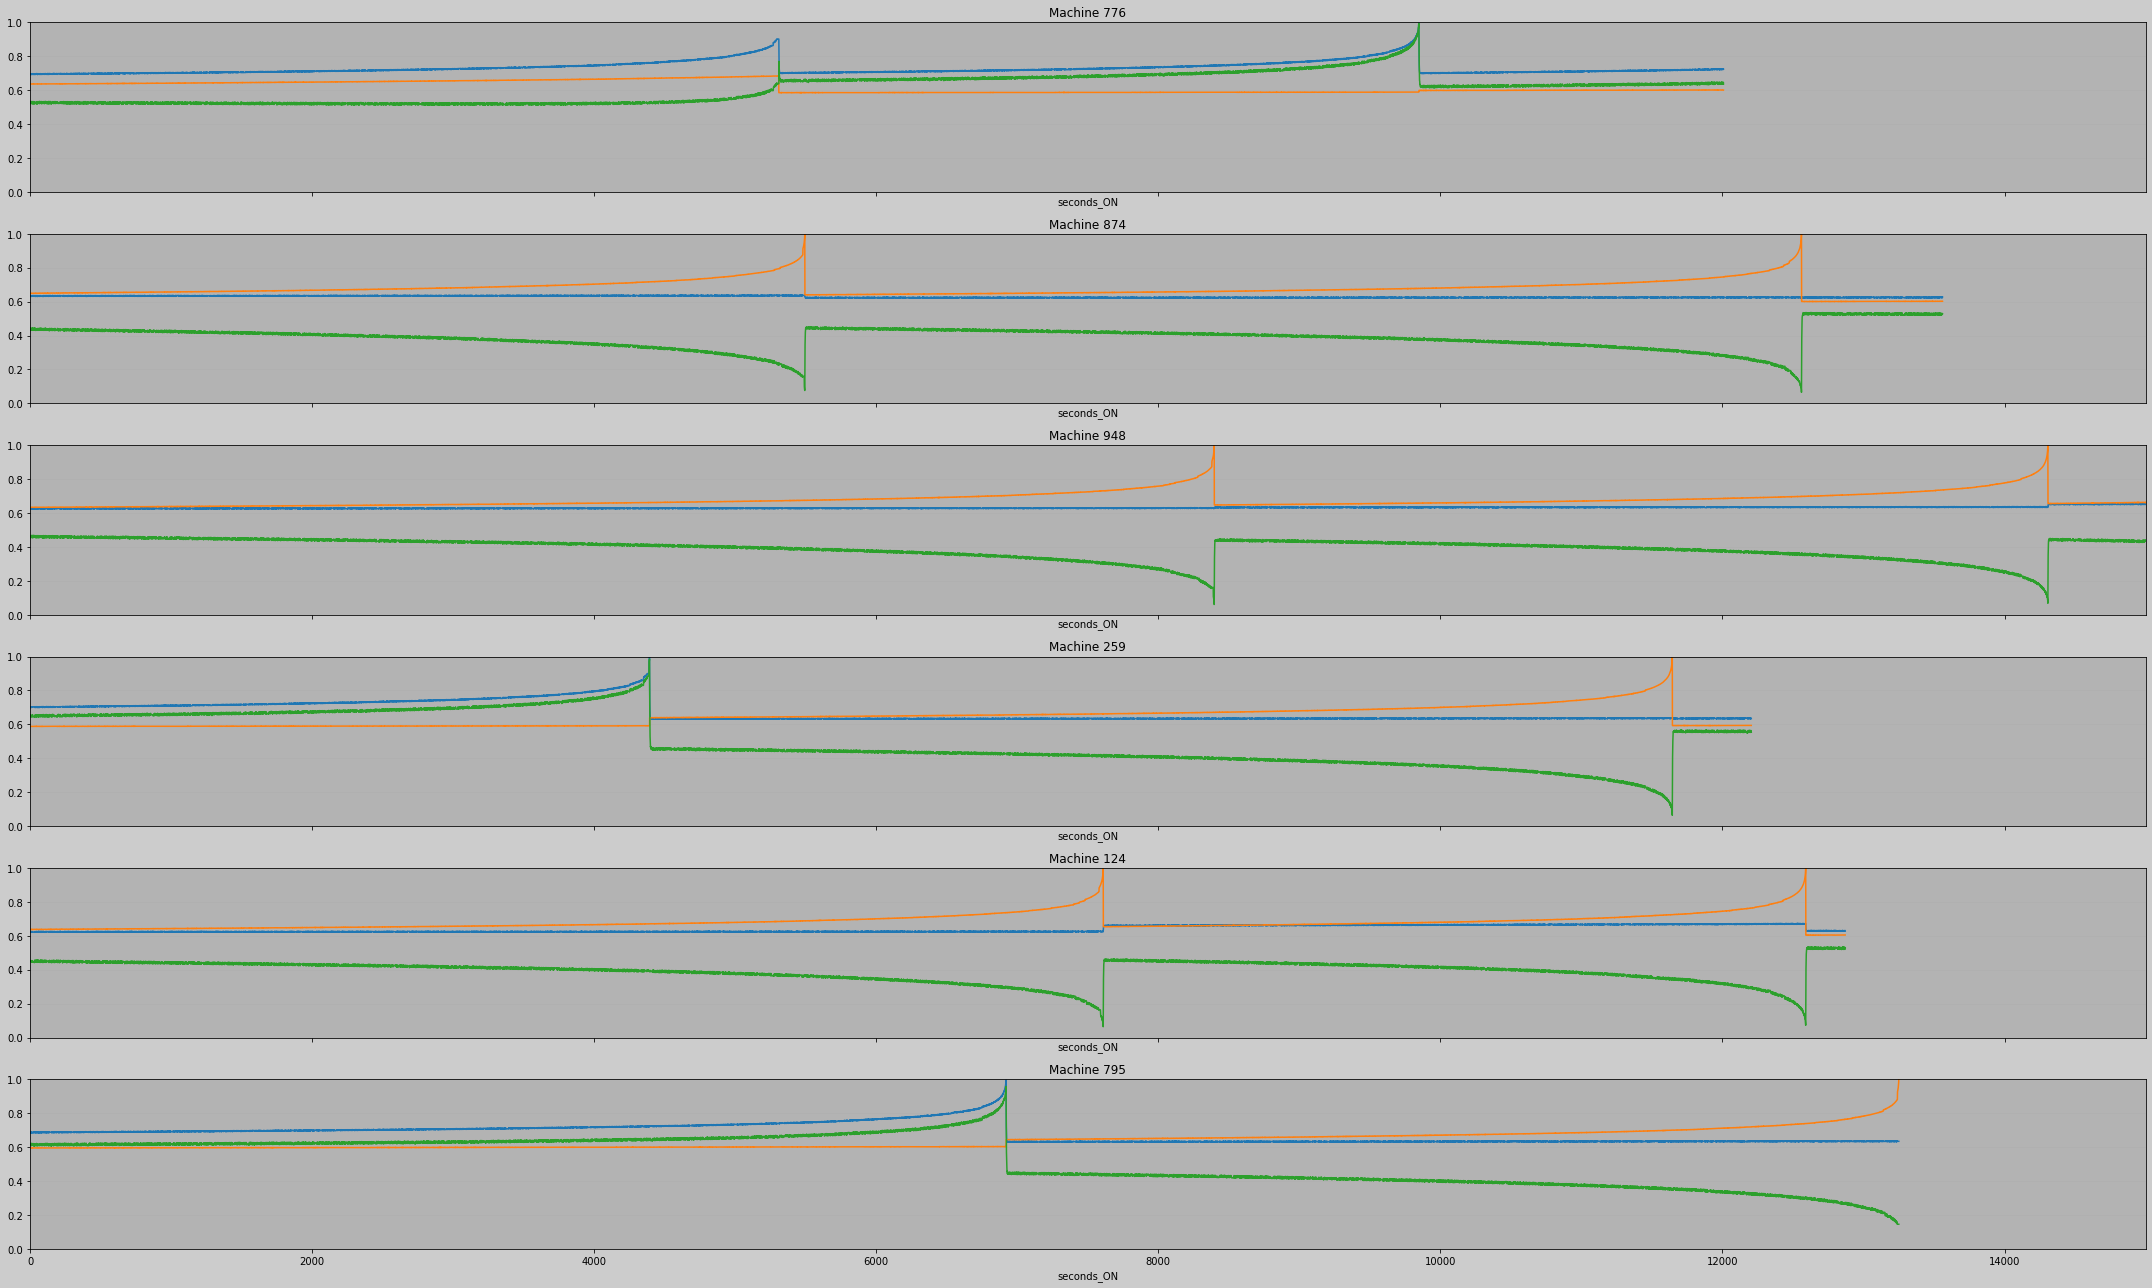

In [21]:
# Affichage des machines ayant eu deux pannes
logs_int_nofix = logs_int.drop(logs_int[logs_int["code"] == 0].index)
logs_int_nofix["dupl"] = logs_int_nofix.duplicated(subset="machineID")
l_dup = logs_int_nofix[logs_int_nofix["dupl"]]["machineID"].tolist()
m = len(l_dup)
fig, axs = plt.subplots(m, 1, sharex=True, sharey=True, figsize=(30, m * 3))
for j, i in enumerate(l_dup):
    df = parc_lisse[i].reset_index(inplace=False)
    axs[j].plot(df[["speed", "temperature", "pressure"]])
    axs[j].set_title('Machine '+str(i))
    axs[j].set_xlabel("seconds_ON")
    axs[j].set_xlim([0, 15_000])
    axs[j].set_ylim([0, 1])
    axs[j].grid(axis='y')
    axs[j].figsize=(20, 5)
    axs[j].set_facecolor("0.7")
fig.set_facecolor("0.8")
plt.tight_layout()
plt.show()

# Etiquetage

On ajoute aux données du parc les "temps-avant-panne" pour chaque type de panne (ainsi que les "temps-depuis-réparation"), toujours comptés en "secondes_ON".
On commence donc par construire un DataFrame `logs_ON` qui ajoute ces données à `logs_int`.

On choisit une durée maximum pour les temps-avant-panne, `maxi`, c'est-à-dire que dès que l'on sait qu'une machine ne connaîtra pas de panne pendant les `maxi` prochaines secondes, alors on indique que le temps-avant-panne est `maxi` (même si on sait que c'est `maxi` + 1000). Ce maximum sert aussi à enlever certaines données: si on a une donnée de télémétrie à moins de `maxi` de la fin des mesures (à m, alors on se peut connaître le temps avant panne.

Augmenter `maxi` permet donc de prédire des pannes plus lointaines, mais enlève des données d'entraînement. (On peut peut-être contourner un peu le problème en prenant deux maximums différents pour chacun de ces rôles.)

Le but final reste à préciser avec le client:
- savoir dans combien de temps une machine donnée va tomber en panne ?
- connaître la probabilité qu'elle tombe en panne dans le prochain cycle allumé (quelques minutes), ou dans les prochaines heures ?

Dans tous les cas, l'étiquetage par "secondes-avant-pannes" semble être la bonne premier étape.

Les graphes montrent que la température est un bon prédicteur pour les pannes de type F1 et la vitesse pour les pannes de type F2. La pression décroît avant les pannes de type F1 et croît avant celles de type F2.

In [22]:
def logsON(logs: pd.DataFrame = logs_int, parc_lisse: List[pd.DataFrame] = parc_lisse) -> pd.DataFrame:
    """Retourne un DataFrame de logs avec une colonne supplémentaire
    'seconds_ON' qui indique le nombre de secondes écoulées où la machine
    donnée est en fonctionnement.
    """
    df = logs.copy()
    df["seconds_ON"] = pd.NA
    for event in df.itertuples():
        df1 = parc_lisse[event.machineID]
        if event.code != 0: # panne
            # on indique le dernier instant "ON" avant la panne:
            df.loc[event.Index,"seconds_ON"] = np.max(np.asarray(df1['seconds'] <= event.seconds).nonzero()[0])
        else: # réparation
            # on indique le premier instant "ON" après la réparation:
            df2 = np.asarray(df1['seconds'] >= event.seconds).nonzero()[0]
            if df2.size != 0:
                df.loc[event.Index,"seconds_ON"] = np.min(df2)
            else:
                # s'il n'y a pas de tel instant (en fin de période),
                # alors on indique le dernier instant "ON" avant la réparation:
                df.loc[event.Index,"seconds_ON"] = np.max(np.asarray(df1['seconds'] <= event.seconds).nonzero()[0])
    return df

In [23]:
logs_ON = logsON(logs_int, parc_lisse)
#display(logs_ON.head(1))

In [24]:
def recupere_pannes(logs: pd.DataFrame = logs_int) -> [List[List[int]], List[List[int]], List[List[int]]]:
    """Retourne une liste de trois listes, où dans chacune, l'élément indicé
    par le machineID est la liste des instants de réparation (0) ou de panne
    de type 1 ou 2, respectivement.
    """
    pannes = [[[] for _ in range(1000)] for i in range(3)]
    for row in logs.itertuples(index=False):
        pannes[row.code][row.machineID].append(row.seconds_ON)
    return pannes

In [25]:
pannes = recupere_pannes(logs_ON)

In [26]:
def etiquette_machine(tele_lisse: pd.DataFrame, pannes = pannes, maxi: int = 100 * 60) -> pd.DataFrame:
    """Retourne le DataFrame étiqueté associé au DataFrame donné. Les
    étiquettes sont les quatres colonnes donnant les temps jusqu'à la
    prochaine panne, la prochaine panne de type F1 ou F2, et depuis la
    dernière réparation.
    """
    df = tele_lisse.copy()
    mac = int(df.iloc[0]["machineID"])
    s = df.index.isin(pannes[0][mac]).cumsum()
    df["from_fix"] = np.where(s>0,df.groupby(s).cumcount(), np.nan)
    first_fix = pannes[0][mac][0] if pannes[0][mac] else len(df)
    if maxi < first_fix:
        df.loc[maxi:first_fix, "from_fix"] = maxi
    for code in range(1, 3):
        s = df[::-1].index.isin(pannes[code][mac]).cumsum()[::-1]
        st = "to_F" + str(code)
        df[st] = np.where(s>0,df.groupby(s).cumcount(ascending=False), np.nan)
    last_F1 = pannes[1][mac][-1] if pannes[1][mac] else -1
    if last_F1 < len(df) - maxi:
        df.loc[last_F1 + 1:len(df) - maxi, "to_F1"] = maxi
    last_F2 = pannes[2][mac][-1] if pannes[2][mac] else -1
    if last_F2 < len(df) - maxi:
        df.loc[last_F2 + 1:len(df) - maxi, "to_F2"] = maxi
    df["to_break"] = np.fmin(df["to_F1"], df["to_F2"])
    df[["from_fix", "to_F1", "to_F2", "to_break"]] = df[["from_fix", "to_F1", "to_F2", "to_break"]].clip(upper=maxi)
    # on ne voit que la prochaine panne, pas la suivante:
    df["to_F1"] = np.where(df["to_F2"] < df["to_F1"] -.5, np.nan, df["to_F1"])
    df["to_F2"] = np.where(df["to_F1"] < df["to_F2"] -.5, np.nan, df["to_F2"])
    return df

In [27]:
%%time
# Création du parc étiqueté:
parc_etiquete = [etiquette_machine(tele_lisse, pannes=pannes, maxi=100 * 60) for tele_lisse in parc_lisse]
#display(parc_etiquete[0].head(1))

CPU times: user 10.7 s, sys: 232 ms, total: 10.9 s
Wall time: 10.9 s


In [28]:
maxi = 100 * 60 # 100 minutes (1h 40min) de fonctionnement

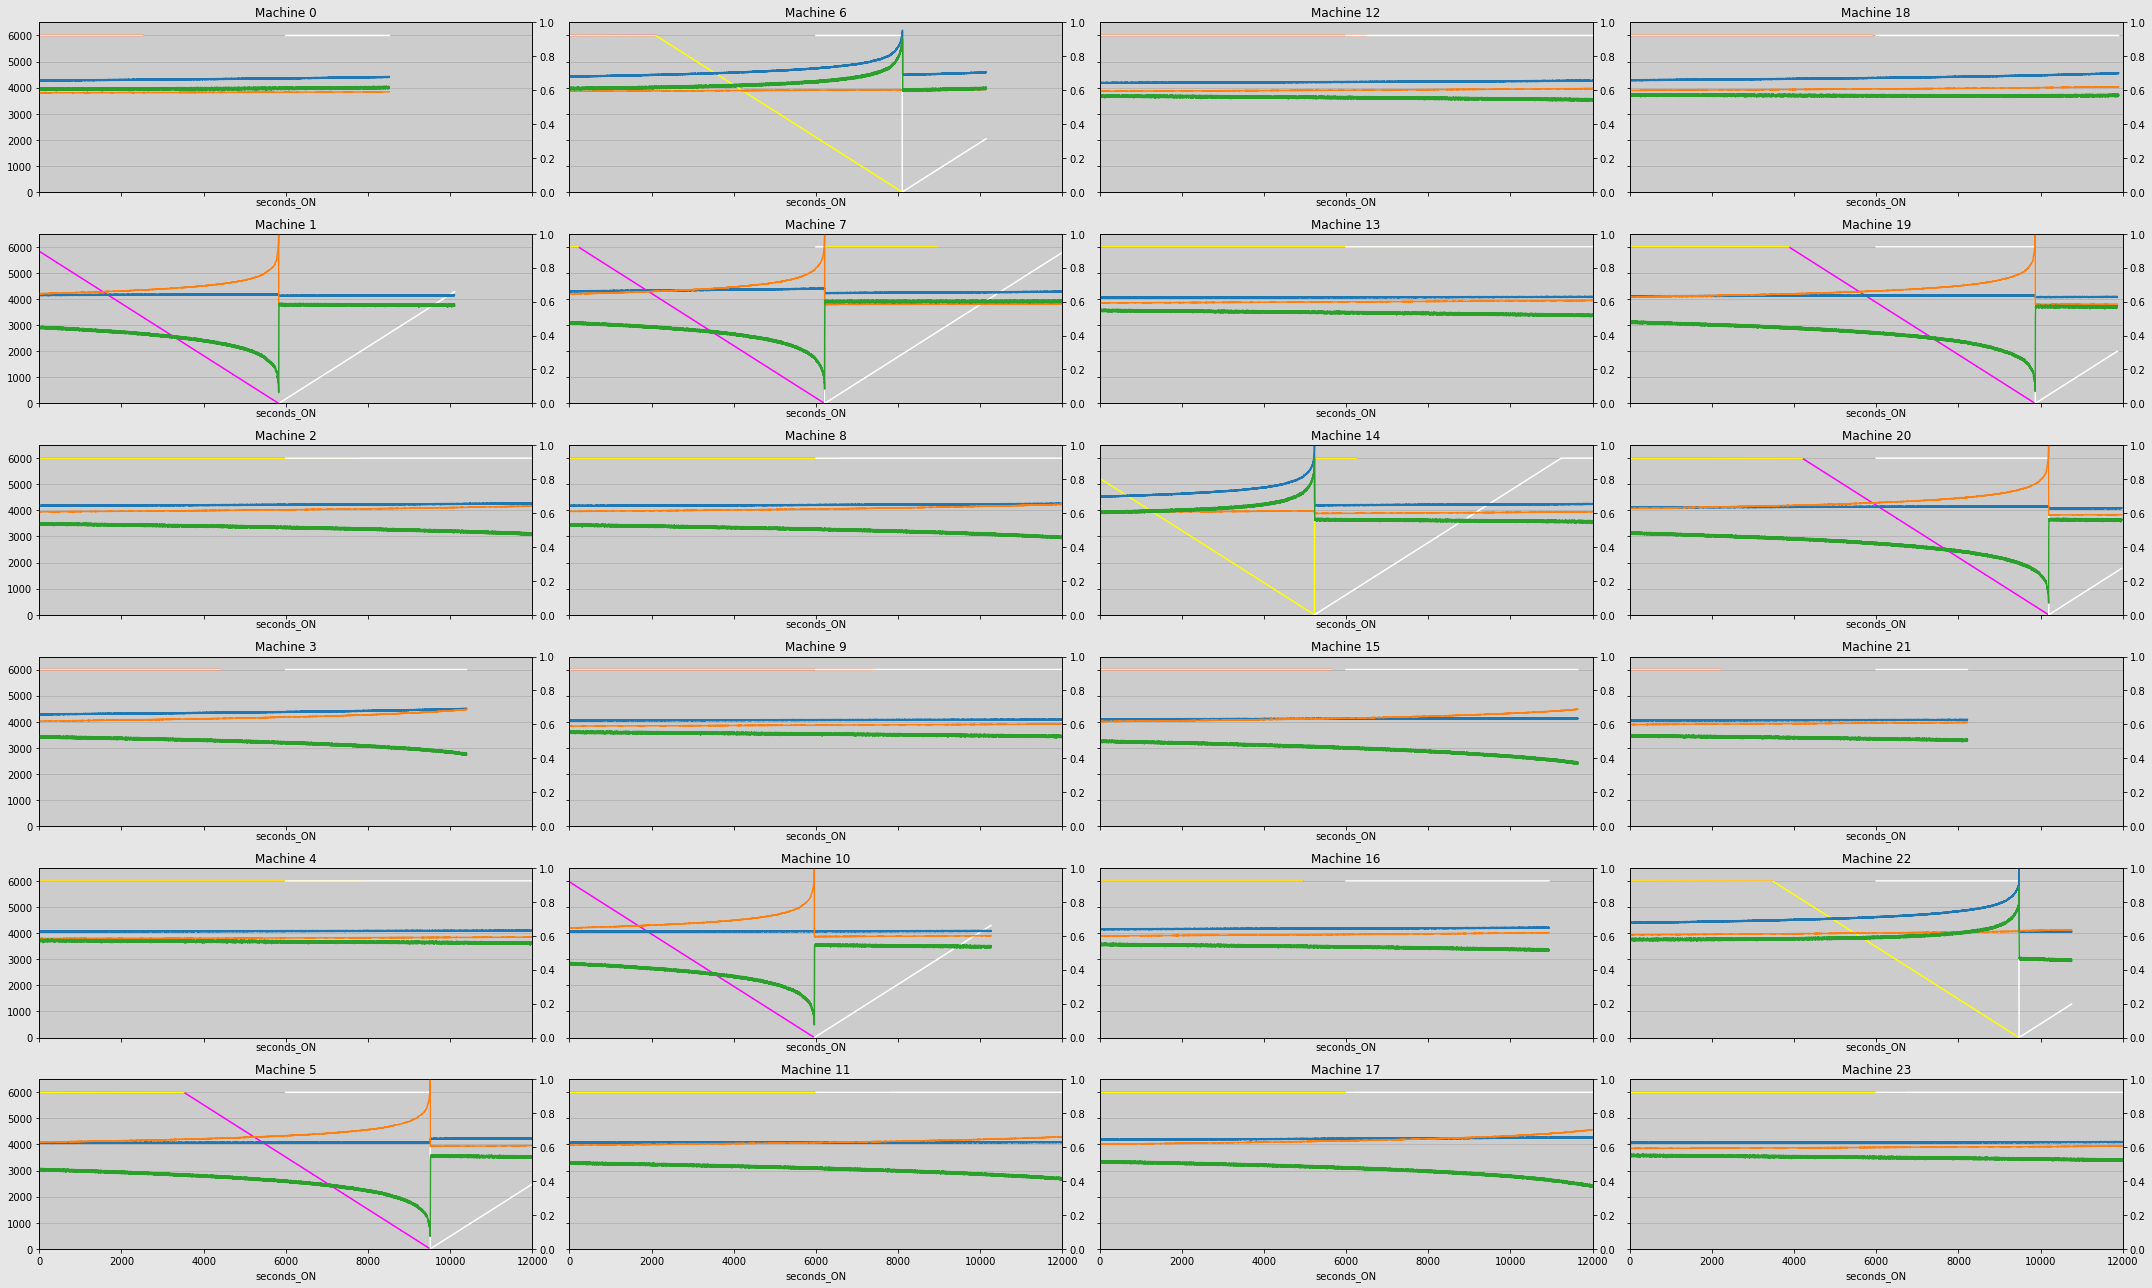

In [29]:
# Affichage de n machines sur col colonnes, avec temps avant pannes
n = 24
col = 4
m = 1 + (n - 1) // col
fig, axs = plt.subplots(m, col, sharex=True, sharey=True, figsize=(30, n * 3 / col))
axs2 = axs[:]
for i in range(n):
    j = (i % m, i // m)
    df = parc_etiquete[i].reset_index(inplace=False)
    axs[j].plot(df["to_F1"], c=(1,0,1))
    axs[j].plot(df["to_F2"], c=(1,1,0))
    axs[j].plot(df["from_fix"], c=(1,1,1))
    axs[j].set_title('Machine '+str(i))
    axs[j].set_xlabel("seconds_ON")
    axs[j].set_xlim([0, 12_000])
    axs[j].set_ylim([0, maxi + 500])
    axs[j].grid(axis='y')
    axs[j].figsize=(20, 5)
    axs[j].set_facecolor("0.8")
    axs2[j] = axs[j].twinx()
    axs2[j].plot(df[["speed", "temperature", "pressure"]])
    axs2[j].set_ylim([0, 1])
fig.set_facecolor("0.9")
plt.tight_layout()
plt.show()

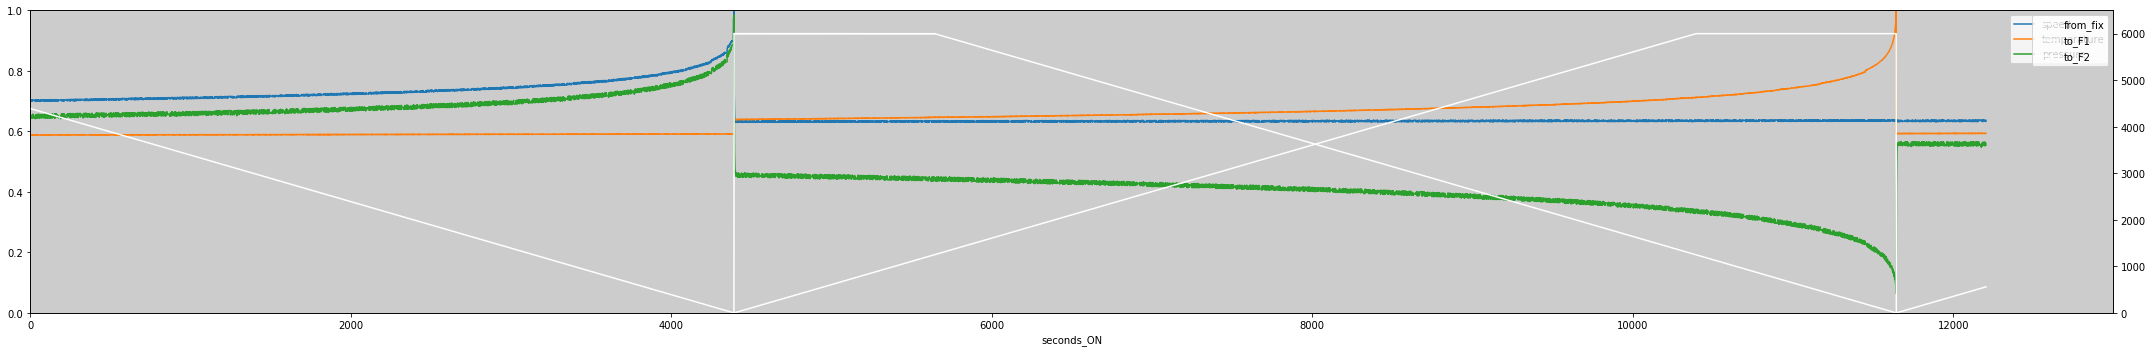

In [30]:
# Affichage pour une machine ayant connu une panne de chaque code.
ax = plt.gca()
parc_etiquete[259].plot(y=["speed", "temperature", "pressure"], ax=ax, figsize=(30, 5))
ax.set_xlim([0, 13_000])
ax.set_ylim([0, 1])
ax.set_facecolor("0.8")
ax2 = ax.twinx()
parc_etiquete[259].plot(y=["from_fix", "to_F1", "to_F2"], ax=ax2, figsize=(30, 5), c=(1,1,1))
ax2.set_ylim([0, maxi + 500])
ax2.set_facecolor("0.8")
plt.tight_layout()
plt.show()

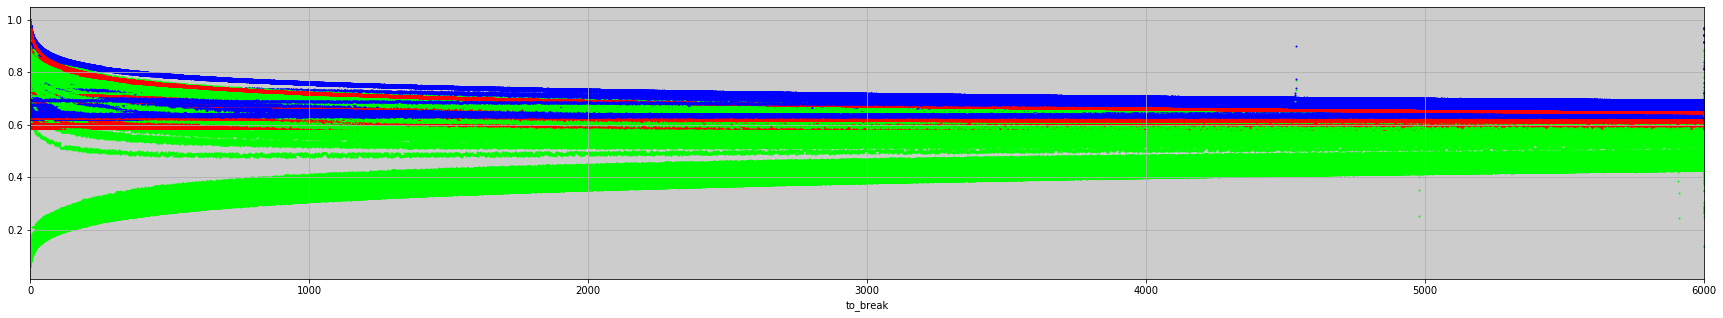

CPU times: user 1min 58s, sys: 55.4 s, total: 2min 53s
Wall time: 1min 29s


In [31]:
%%time
# Affichage des conditions en fonction du temps-avant-panne pour l'ensemble du parc.
# On voit que ce serait difficilement prédictible directement: heureusement, les
# données de maintenance précisent le type de panne.
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n_machines):
    ax.scatter(x=parc_etiquete[i]["to_break"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_etiquete[i]["to_break"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_etiquete[i]["to_break"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_break")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

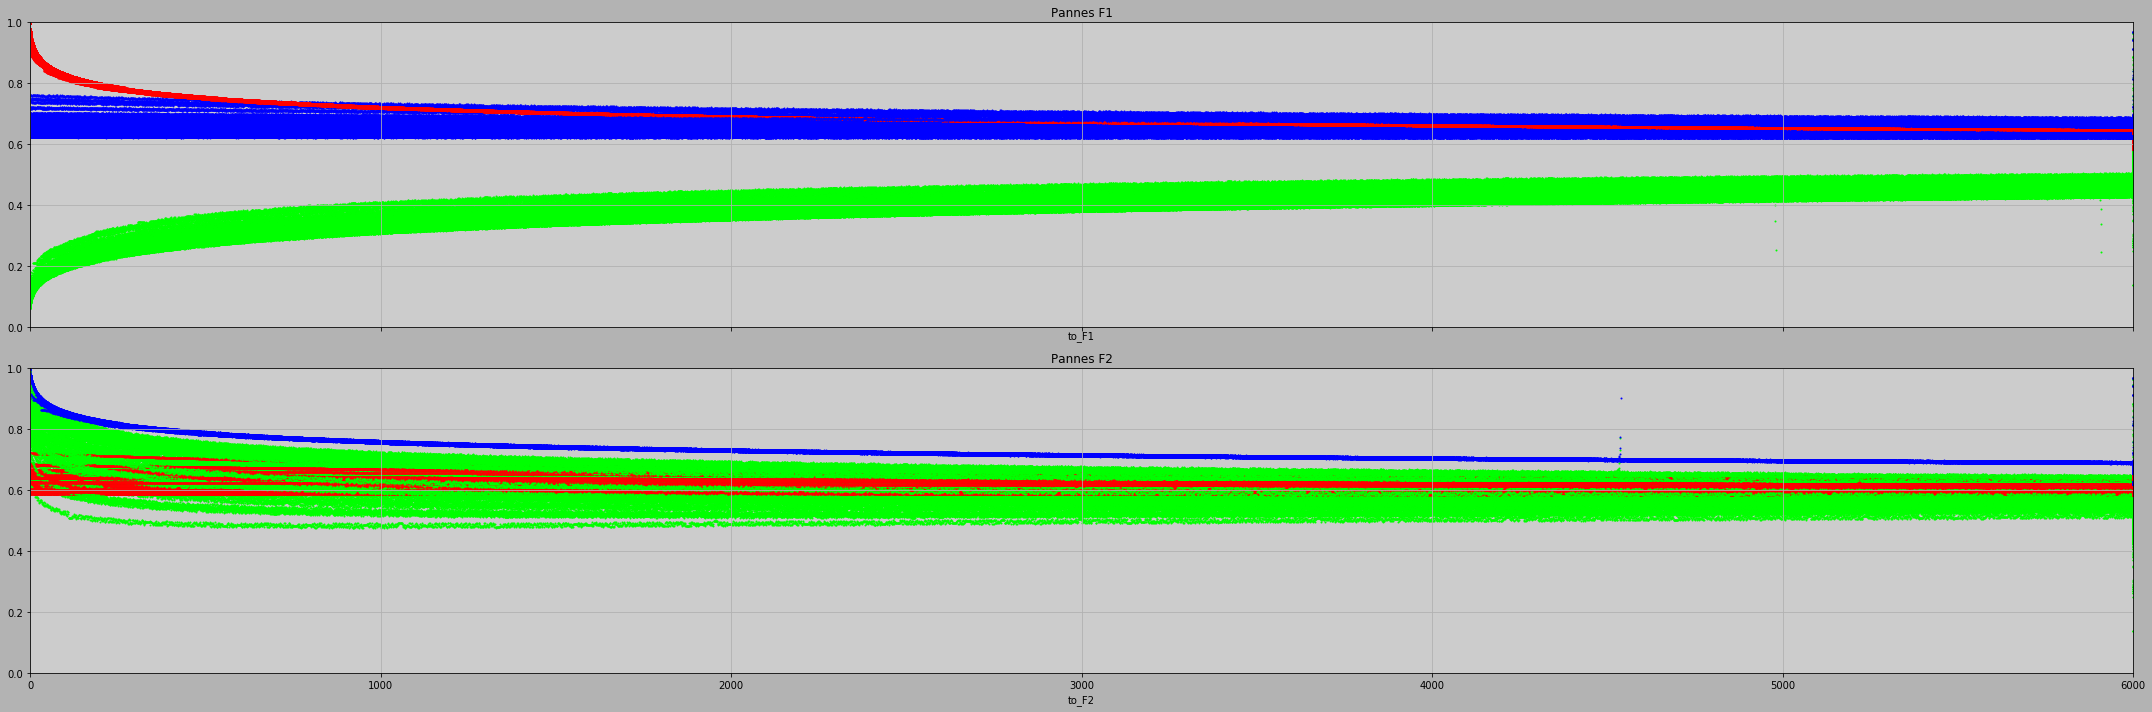

CPU times: user 3min 20s, sys: 55.5 s, total: 4min 16s
Wall time: 2min 51s


In [32]:
%%time
# Affichage des conditions en fonction du temps-avant-panne pour l'ensemble du parc.
# On voit que:
# - la température sera le principal prédicteur pour la panne F1.
# - la vitesse sera le principal prédicteur pour la panne F2.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 10))
ax1.title.set_text('Pannes F1')
for i in range(n_machines):
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax1.set_xlabel("to_F1")
ax1.set_xlim(0, maxi)
ax1.set_ylim(0, 1)
ax1.set_facecolor("0.8")
ax1.grid(True)

ax2.title.set_text('Pannes F2')
for i in range(n_machines):
    ax2.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax2.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax2.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax2.set_xlabel("to_F2")
ax2.set_facecolor("0.8")
ax2.grid(True)

fig.set_facecolor("0.7")
plt.tight_layout()
plt.show()

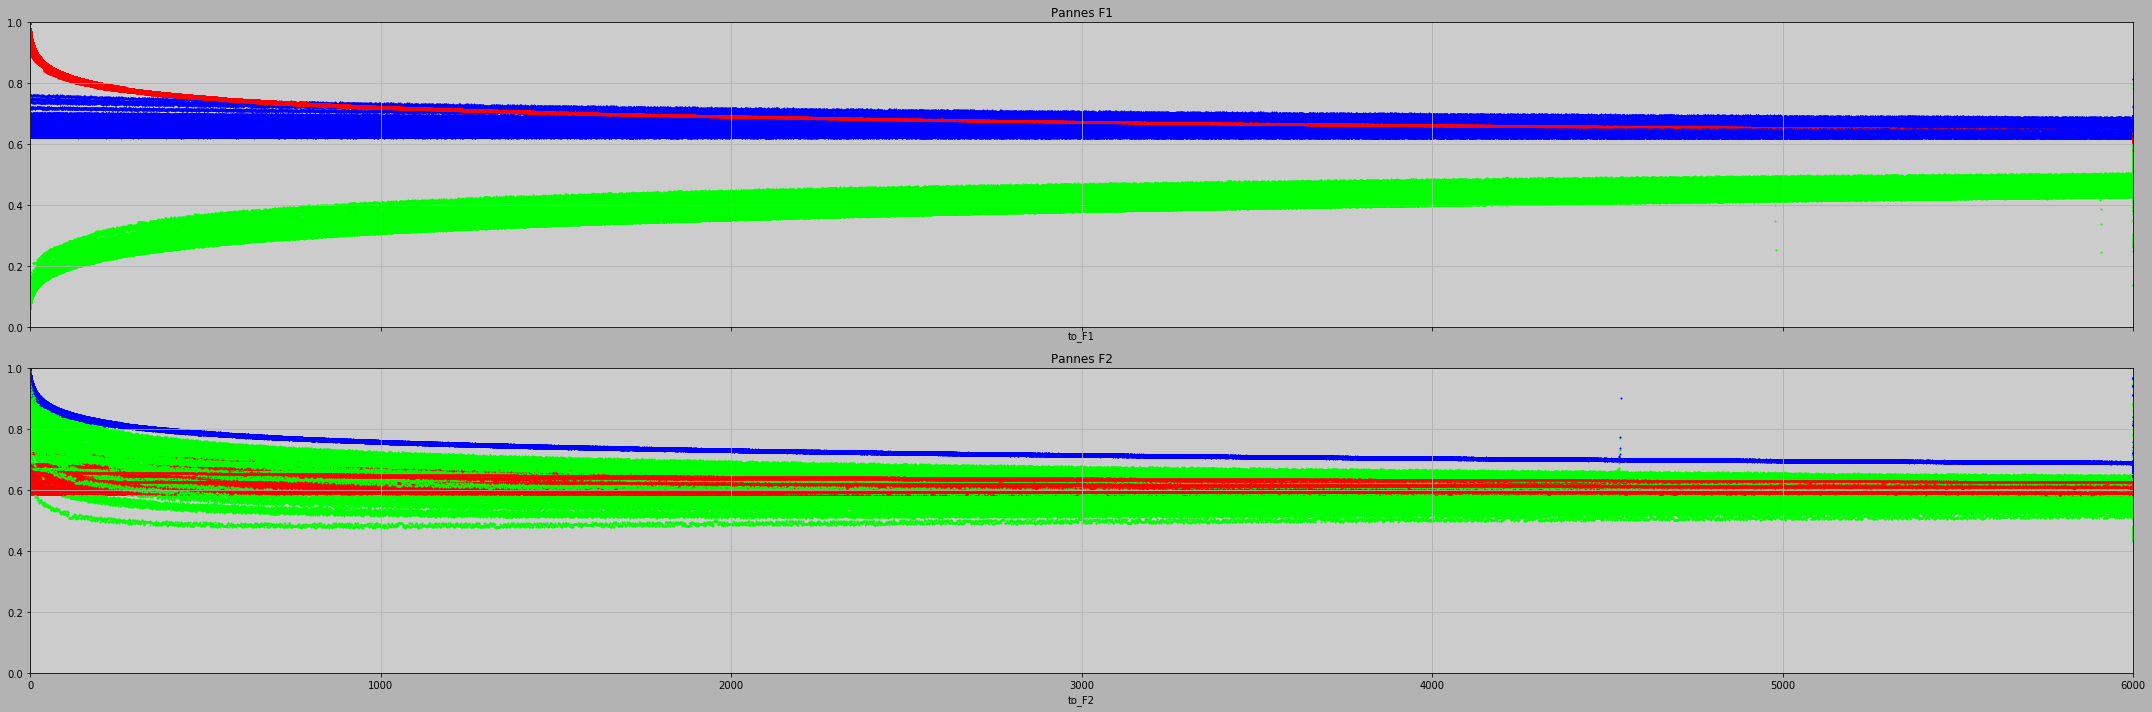

CPU times: user 31.5 s, sys: 10.9 s, total: 42.5 s
Wall time: 26 s


In [33]:
%%time
# Affichage des conditions en fonction du temps-avant-panne pour les machines ayant une panne du type donné.
fig, (ax1, ax2 ) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 10))
ax1.title.set_text('Pannes F1')
for i in mac_panne[0]:
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax1.set_xlabel("to_F1")
ax1.set_xlim(0, maxi)
ax1.set_ylim([0, 1])
ax1.set_facecolor("0.8")
ax1.grid(True)

ax2.title.set_text('Pannes F2')
for i in mac_panne[1]:
    ax2.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax2.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax2.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax2.set_xlabel("to_F2")
ax2.set_facecolor("0.8")
ax2.grid(True)

fig.set_facecolor("0.7")
plt.tight_layout()
plt.show()

# Régression (fausse piste)
Pour à la fois lisser les données et ajouter un "indice" au ML, on fait des régressions linéaires des conditions (vitesse, température, pression) de chaque machine à chaque instant, sur les `delai_reg=15` secondes précédentes.
Il doit exister des méthodes pour faire des régressions "glissantes" plus rapidement, mais ici `delai_reg` reste petit.

In [34]:
def linreg(l):
    """A partir d'une liste d'entiers l, retourne le couple (pente, intercept) donnée
    par régression linéaire classique (moindres carrés) du nuage de points
    {(1-m, l[0]), (2-m, l[1]), ..., (0, l[m-1])}
    où m est la longueur de l.
    
    Appelée sur une liste de listes, la fonction retourn une liste de couples
    (pente, intercept) pour chaque régression.
    """
    m = len(l)
    a = np.arange(1-m, 1).reshape(m, 1)
    res = np.array(list(l))
    reg = LinearRegression().fit(a, l)
    try:
        coefs = np.block(reg.coef_.transpose())[0]
    except IndexError:
        coefs = np.block(reg.coef_.transpose())
    intercepts = reg.intercept_
    return coefs, intercepts

In [35]:
def regress(tele_etiquete: pd.DataFrame, delai_reg: int = 15) -> pd.DataFrame:
    """Retourn un DataFrame avec des colonnes supplémentaires avec les données
    de régression des conditions.
    """
    df = tele_etiquete.copy()
    for i in range(delai_reg + 1): #on répète la colonne à l'instant donné (i=0) par simplicité
        si = "speed" + str(i)
        ti = "temp" + str(i)
        pi = "press" + str(i)
        df[si] = df["speed"].shift(i)
        df[ti] = df["temperature"].shift(i)
        df[pi] = df["pressure"].shift(i)
    # Suppression des `delai_reg` première données, puisque l'historique n'est pas disponible
    df = df.iloc[delai_reg:]
    # Suppression des données juste après une réparation, puisque l'historique n'est pas pertinent
    # (on pourrait aussi imposer pour la regression une pente de 0 et une moyenne égale à la valeur
    # présente, mais le nombre de données est négligeable).
    df = df[~(df["from_fix"] <= delai_reg)]
    # Calcul des régressions:
    df["speed_slope"], df["speed_0"] = linreg([df["speed"+str(i)] for i in range(delai_reg+1)])
    df["temp_slope"], df["temp_0"] = linreg([df["temp"+str(i)] for i in range(delai_reg+1)])
    df["press_slope"], df["press_0"] = linreg([df["press"+str(i)] for i in range(delai_reg+1)])
    # Suppression des colonnes temporaires:
    for i in range(delai_reg + 1):
        si = "speed" + str(i)
        ti = "temp" + str(i)
        pi = "press" + str(i)
        df = df.drop([si, ti, pi], axis=1)
    return df

In [36]:
%%time
# Création du parc avec régressions:
parc_reg = [regress(tele_etiquete, delai_reg=15) for tele_etiquete in parc_etiquete]
#display(parc_reg[0].head(1))

CPU times: user 8min 15s, sys: 9min 32s, total: 17min 47s
Wall time: 3min 17s


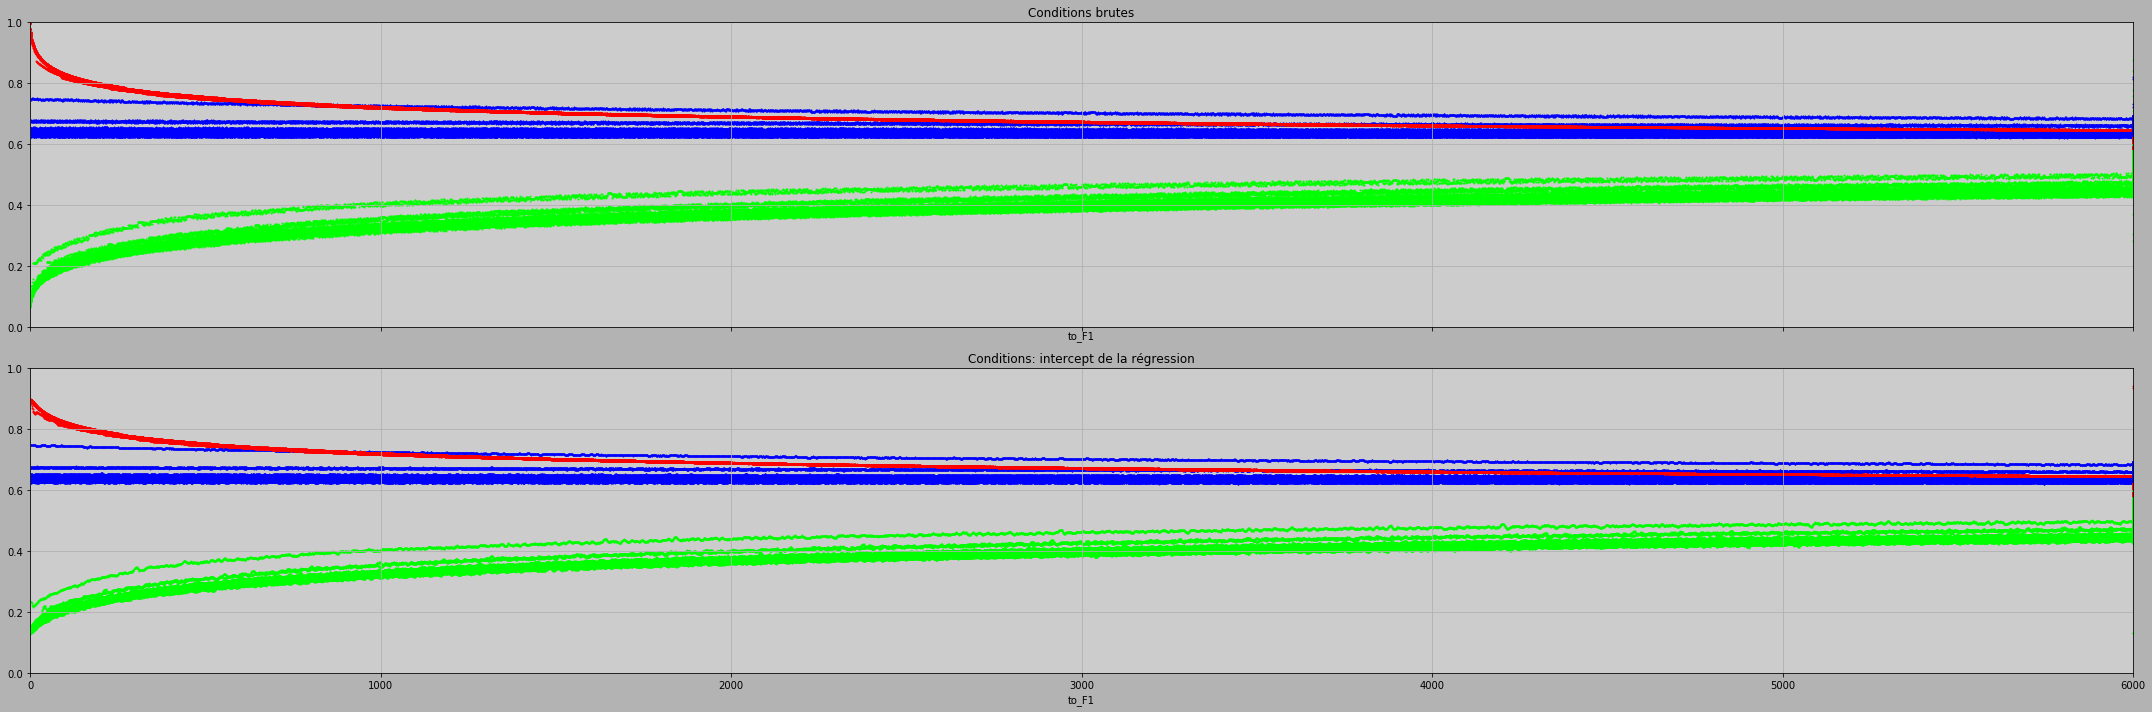

In [37]:
# Affichage des conditions en fonction du temps-avant-panne F1 pour les n premières machines,
# brutes puis lissées.
# Le coefficient constant de la régression agit comme une moyenne et lisse: le deuxième graphe
# est un peu plus propre, particulièrement pour la pression.
n = 100
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 10))
ax1.title.set_text('Conditions brutes')
for i in range(n):
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax1.set_xlabel("to_F1")
ax1.set_xlim(0, maxi)
ax1.set_ylim(0, 1)
ax1.set_facecolor("0.8")
ax1.grid(True)

ax2.title.set_text('Conditions: intercept de la régression')
for i in range(n):
    ax2.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["temp_0"], s=1, c=[[1,0,0]])
    ax2.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["press_0"], s=1, c=[[0,1,0]])
    ax2.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["speed_0"], s=1, c=[[0,0,1]])
ax2.set_xlabel("to_F1")
ax2.set_facecolor("0.8")
ax2.grid(True)

fig.set_facecolor("0.7")
plt.tight_layout()
plt.show()

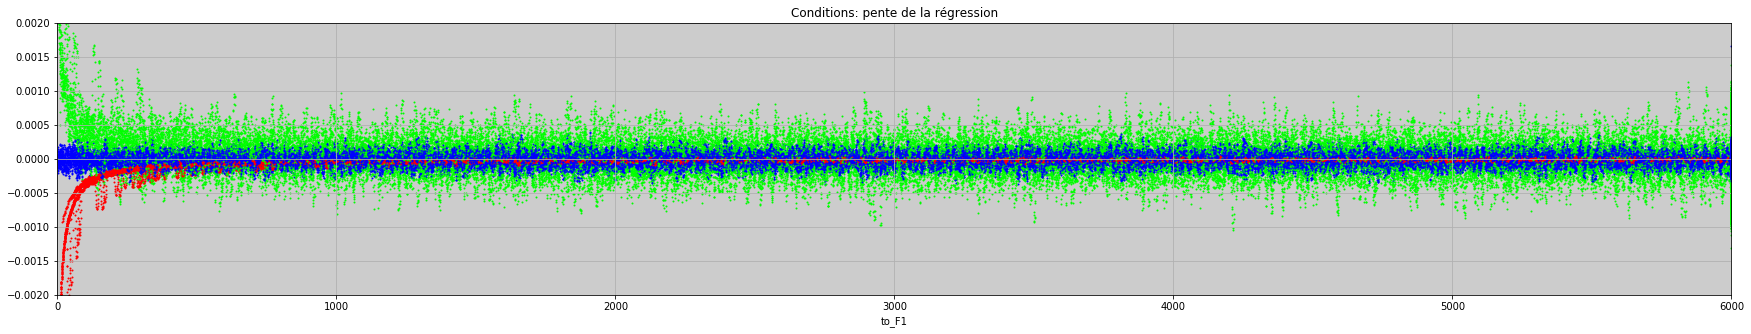

In [38]:
# Affichage des pentes des conditions pour les n premières machines.
n = 30
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
ax.title.set_text('Conditions: pente de la régression')
for i in range(n):
    ax.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["temp_slope"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["press_slope"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["speed_slope"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_ylim(-0.002, 0.002)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

La régression était donc une fausse piste.

# Lissage par moyenne
Puisque le terme constant des régressions a lissé les courbes, autant calculer une véritable moyenne sur les `delai_moy=10` secondes précédentes.

In [39]:
def moyennage(tele_etiquete: pd.DataFrame, delai_moy: int = 10) -> pd.DataFrame:
    df = tele_etiquete.copy()
    for i in range(delai_moy + 1): #on répète la colonne à l'instant donné (i=0) par simplicité
        si = "speed" + str(i)
        ti = "temp" + str(i)
        pi = "press" + str(i)
        df[ti] = df["temperature"].shift(i)
        df[pi] = df["pressure"].shift(i)
        df[si] = df["speed"].shift(i)
    # Suppression des `delai_moy` première données, puisque l'historique n'est pas disponible:
    df = df.iloc[delai_moy:]
    # Suppression des données juste après une réparation, puisque l'historique n'est pas pertinent
    # (on pourrait aussi imposer une moyenne égale à la valeur
    # présente, mais le nombre de données est négligeable).
    df = df[~(df["from_fix"] <= delai_moy)]
    # Calcul des moyennes:
    df["temp_mean"] = df[["temp"+str(i) for i in range(delai_moy+1)]].mean(axis=1)
    df["press_mean"] = df[["press"+str(i) for i in range(delai_moy+1)]].mean(axis=1)
    df["speed_mean"] = df[["speed"+str(i) for i in range(delai_moy+1)]].mean(axis=1)
    # Suppression des colonnes temporaires:
    for i in range(delai_moy + 1):
        ti = "temp" + str(i)
        pi = "press" + str(i)
        si = "speed" + str(i)
        df = df.drop([ti, pi, si], axis=1)
    df.drop(["speed", "temperature", "pressure"], axis=1, inplace=True)
    return df

In [40]:
%%time
# Création du parc avec moyennage:
parc_moy = [moyennage(tele_etiquete, delai_moy=15) for tele_etiquete in parc_etiquete]
#display(parc_moy[0].head(1))

CPU times: user 45.9 s, sys: 1.96 s, total: 47.8 s
Wall time: 47.8 s


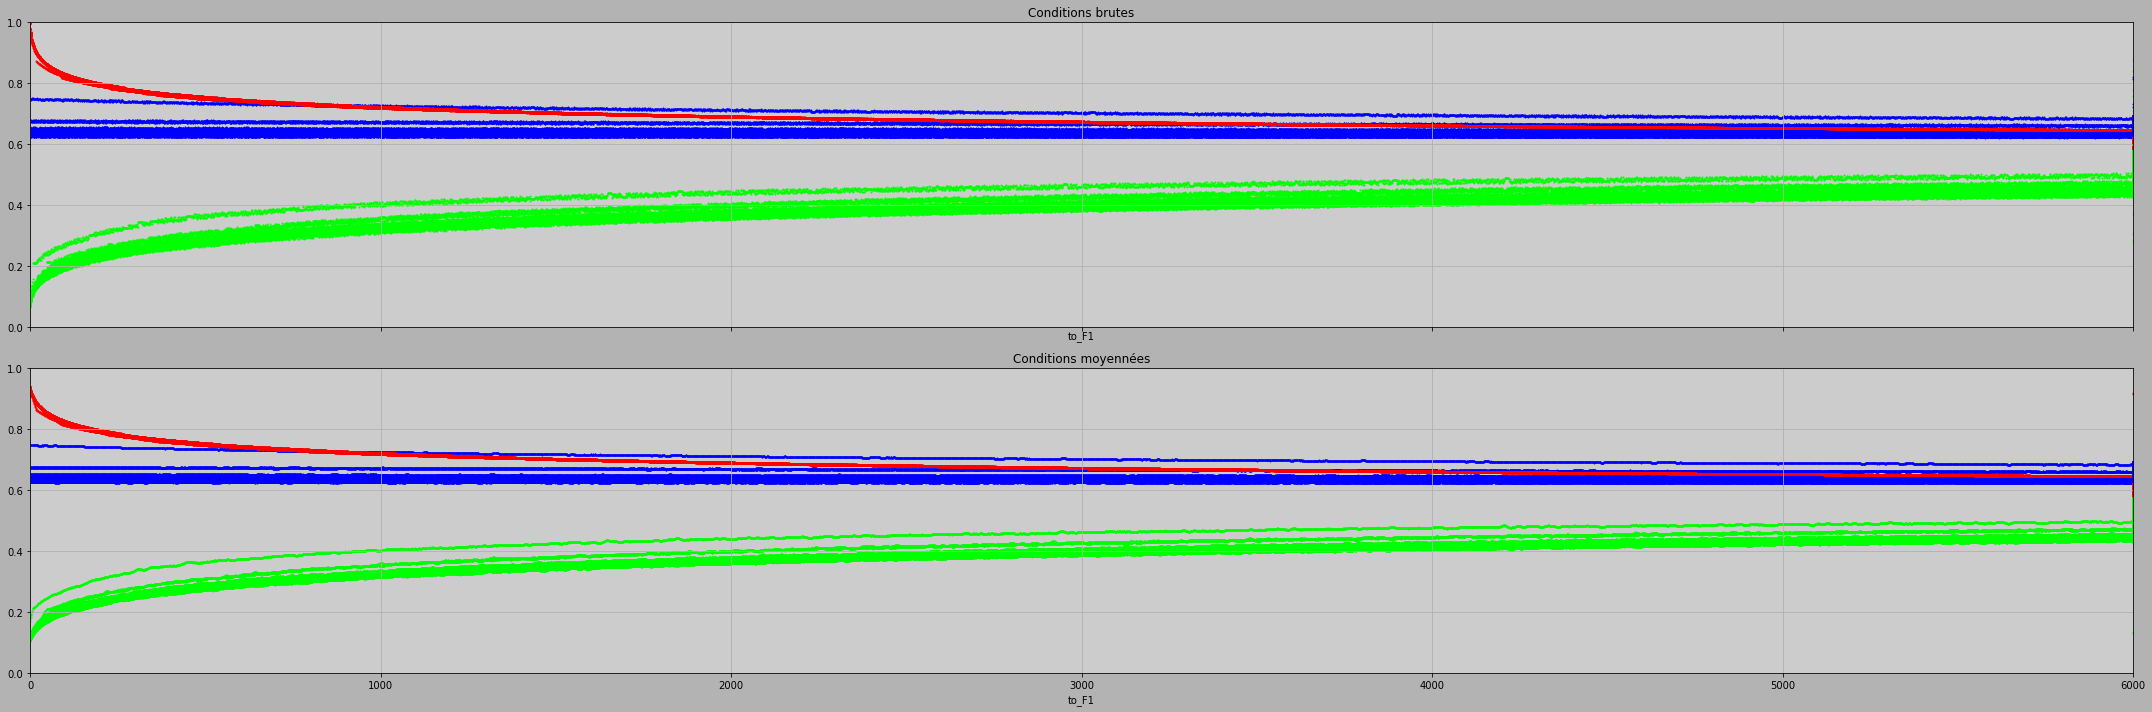

In [41]:
# Affichage des conditions en fonction du temps-avant-panne F1 pour les n premières machines,
# brutes puis moyennées.
# La moyenne lisse les courbes: le deuxième graphe est plus propre, particulièrement pour
# la pression.
n = 100
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 10))
ax1.title.set_text('Conditions brutes')
for i in range(n):
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax1.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax1.set_xlabel("to_F1")
ax1.set_xlim(0, maxi)
ax1.set_ylim(0, 1)
ax1.set_facecolor("0.8")
ax1.grid(True)

ax2.title.set_text('Conditions moyennées')
for i in range(n):
    ax2.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax2.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["press_mean"], s=1, c=[[0,1,0]])
    ax2.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["speed_mean"], s=1, c=[[0,0,1]])
ax2.set_xlabel("to_F1")
ax2.set_facecolor("0.8")
ax2.grid(True)

fig.set_facecolor("0.7")
plt.tight_layout()
plt.show()

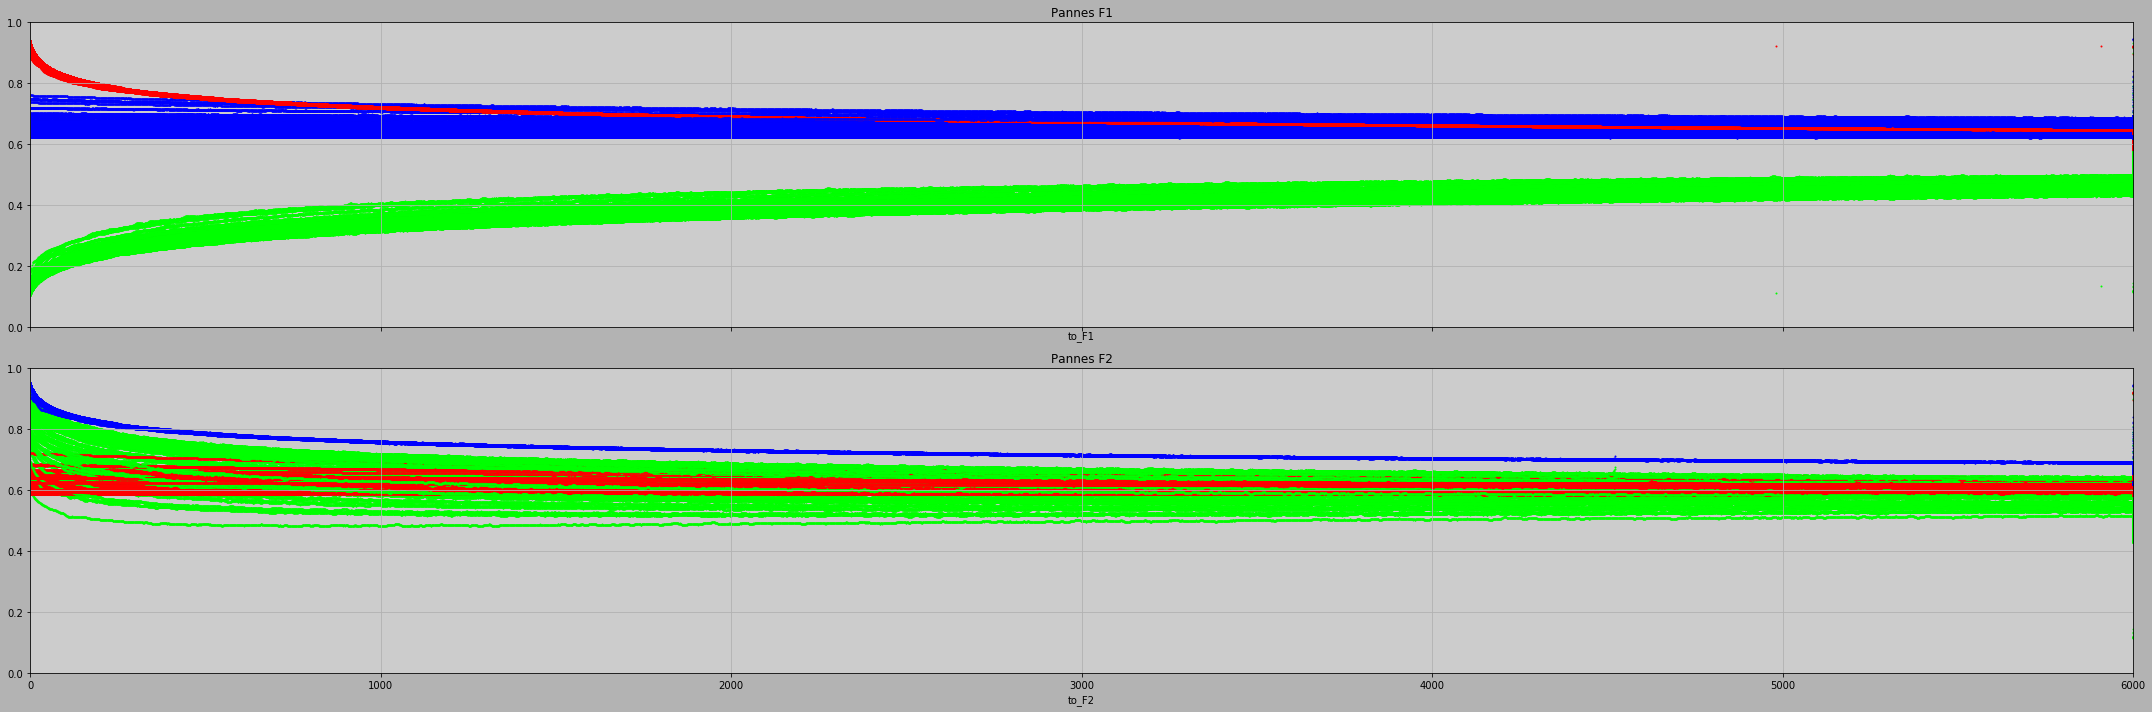

CPU times: user 3min 20s, sys: 55.2 s, total: 4min 15s
Wall time: 2min 50s


In [42]:
%%time
# Affichage des conditions moyennes pour l'ensemble du parc.
n = 1000
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 10))
ax1.title.set_text('Pannes F1')
for i in range(n):
    ax1.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax1.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["press_mean"], s=1, c=[[0,1,0]])
    ax1.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["speed_mean"], s=1, c=[[0,0,1]])
ax1.set_xlabel("to_F1")
ax1.set_xlim(0, maxi)
ax1.set_ylim(0, 1)
ax1.set_facecolor("0.8")
ax1.grid(True)

ax2.title.set_text('Pannes F2')
for i in range(n):
    ax2.scatter(x=parc_moy[i]["to_F2"], y=parc_moy[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax2.scatter(x=parc_moy[i]["to_F2"], y=parc_moy[i]["press_mean"], s=1, c=[[0,1,0]])
    ax2.scatter(x=parc_moy[i]["to_F2"], y=parc_moy[i]["speed_mean"], s=1, c=[[0,0,1]])
ax2.set_xlabel("to_F2")
ax2.set_facecolor("0.8")
ax2.grid(True)

fig.set_facecolor("0.7")
plt.tight_layout()
plt.show()

# Calcul des "dérivées" des conditions (fausse piste)

Les dérivées des conditions pourraient éventuellement aider l'apprentissage automatique.

In [43]:
def cond_diff(tele_moy: pd.DataFrame, delai_diff: int = 100) -> pd.DataFrame:
    df = tele_moy.copy()
    df["temp_delai"] = df["temp_mean"].shift(delai_diff)
    df["press_delai"] = df["press_mean"].shift(delai_diff)
    df["speed_delai"] = df["speed_mean"].shift(delai_diff)
    df = df.iloc[delai_diff:]
    # effacer les données juste après une réparation, puisque l'historique n'est pas pertinent
    # (on pourrait aussi imposer pour la regression une pente de 0 et une moyenne égale à la valeur
    # présente, mais le nombre de données est négligeable).
    df = df[~(df["from_fix"] <= delai_diff)]
    df["temp_diff"] = (1000 / delai_diff) * (df["temp_mean"] - df["temp_delai"])
    df["press_diff"] = (1000 / delai_diff) * (df["press_mean"] - df["press_delai"])
    df["speed_diff"] = (1000 / delai_diff) * (df["speed_mean"] - df["speed_delai"])
    df = df.drop(["temp_delai", "press_delai", "speed_delai"], axis=1)
    return df

In [44]:
%%time
# Création du parc avec dérivées des conditions:
parc_diff = [cond_diff(tele_moy, delai_diff=100) for tele_moy in parc_moy]
#display(parc_diff[0].head(1))

CPU times: user 5.09 s, sys: 71.8 ms, total: 5.16 s
Wall time: 5.16 s


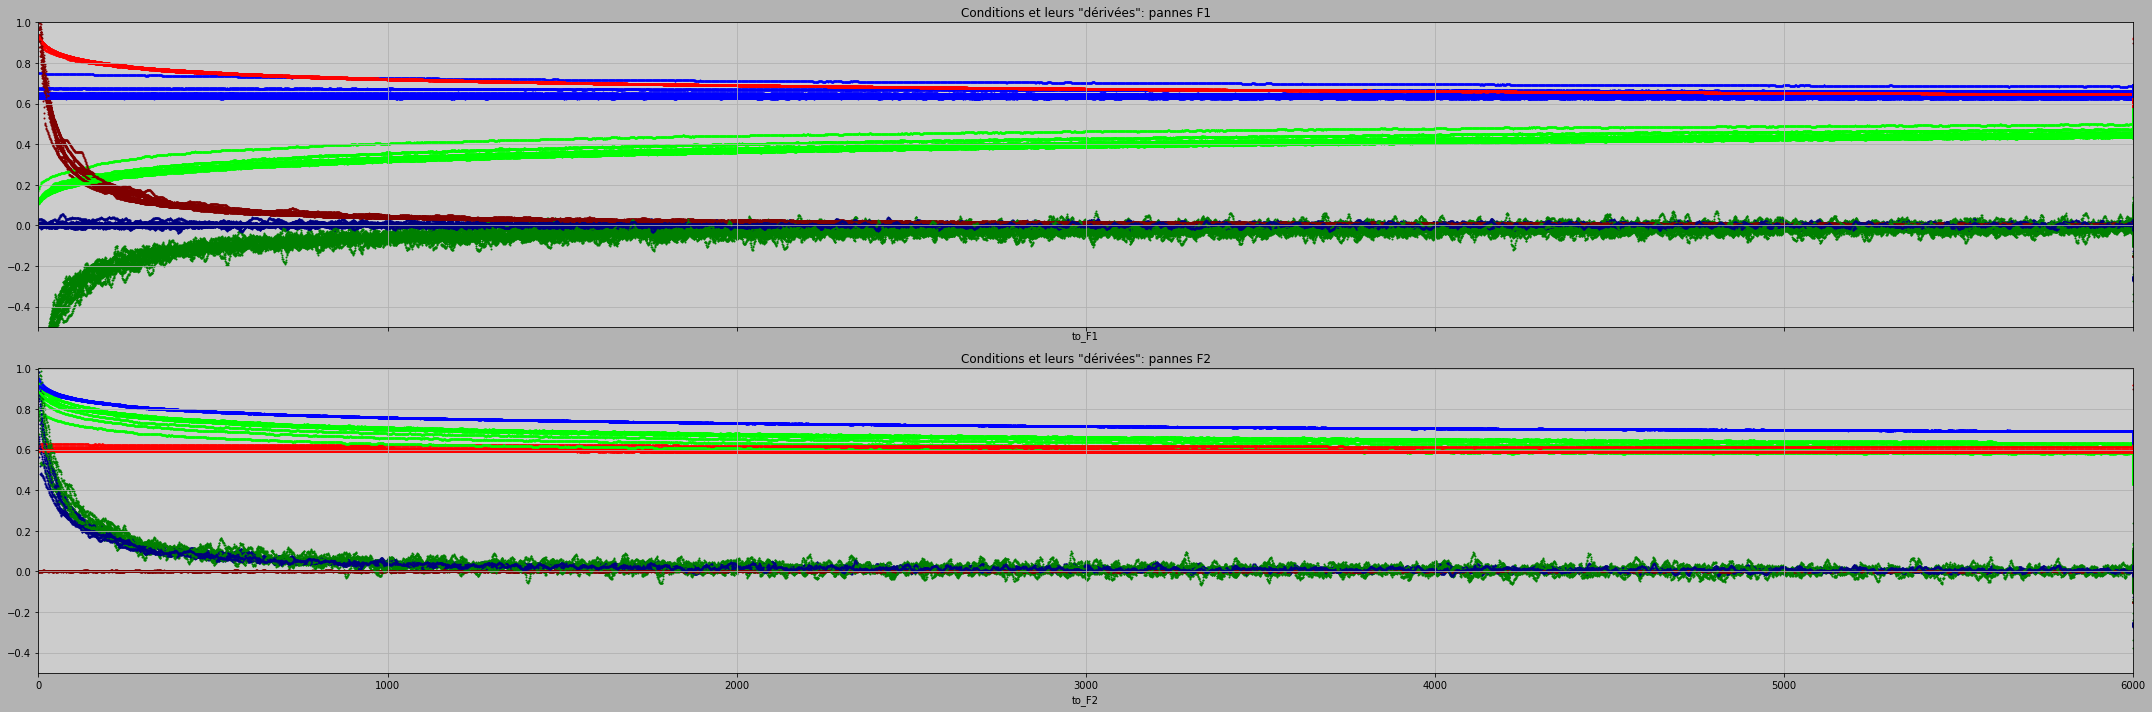

In [45]:
# Affichage des conditions et de leurs dérivées pour chaque type de panne.
n = 100
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 10))
ax1.title.set_text('Conditions et leurs "dérivées": pannes F1')
for i in range(n):
    ax1.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax1.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["press_mean"], s=1, c=[[0,1,0]])
    ax1.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["speed_mean"], s=1, c=[[0,0,1]])
    ax1.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["temp_diff"], s=1, c=[[0.5, 0, 0]])
    ax1.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["press_diff"], s=1, c=[[0, 0.5, 0]])
    ax1.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["speed_diff"], s=1, c=[[0, 0, 0.5]])
ax1.set_xlabel("to_F1")
ax1.set_xlim(0, maxi)
ax1.set_ylim(-.5, 1)
ax1.set_facecolor("0.8")
ax1.grid(True)

ax2.title.set_text('Conditions et leurs "dérivées": pannes F2')
for i in range(n):
    ax2.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax2.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["press_mean"], s=1, c=[[0,1,0]])
    ax2.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["speed_mean"], s=1, c=[[0,0,1]])
    ax2.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["temp_diff"], s=1, c=[[0.5, 0, 0]])
    ax2.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["press_diff"], s=1, c=[[0, 0.5, 0]])
    ax2.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["speed_diff"], s=1, c=[[0, 0, 0.5]])
ax2.set_xlabel("to_F2")
ax2.set_facecolor("0.8")
ax2.grid(True)

fig.set_facecolor("0.7")
plt.tight_layout()
plt.show()

Les dérivées étaient probablement une fausse piste. De façon générale, une dérivée est trop sensible au bruit (la dérivation est une opération instable).

# Visualisation simulanée de deux paramètres (3D)

Visualisation des temps-avant-panne en fonction de deux des trois paramètres, pour chaque code de panne.
(On ne représente les données que pour les machines connaissant effectivement une panne du type donné.)

On voit quelques artefacts qu'il serait peut-être utile d'enlever avant le ML (il y en aurait plus si on représentait l'ensemble des machines; ils sont déjà visibles sur les graphes ci-dessus).

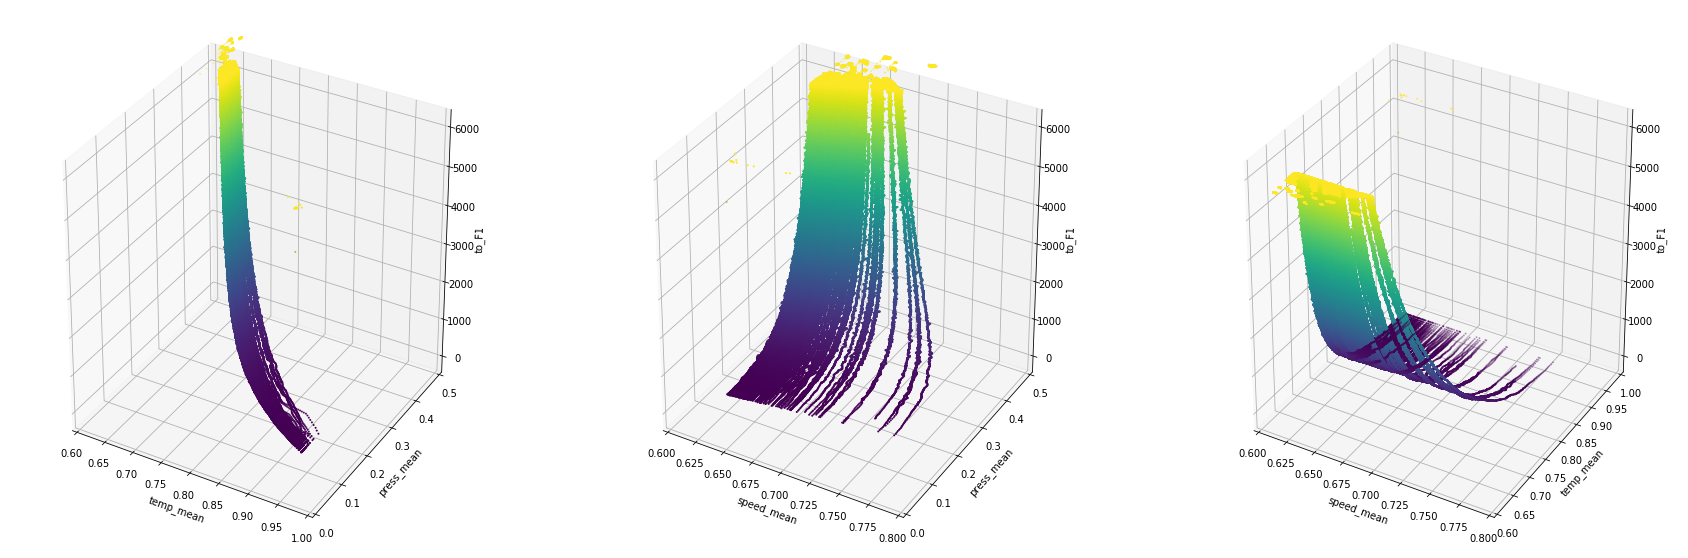

CPU times: user 1min 29s, sys: 523 ms, total: 1min 29s
Wall time: 1min 29s


In [46]:
%%time
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(131, projection='3d')
for i in mac_panne[0]: # pour des raisons de temps de calcul, même si moins complet que "range(n_machines)"
    z = parc_moy[i]["to_F1"]
    ax.scatter(xs=parc_moy[i]["temp_mean"], ys=parc_moy[i]["press_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 1)
ax.set_ylim(0, .5)
ax.set_xlabel('temp_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(132, projection='3d')
for i in mac_panne[0]:
    z = parc_moy[i]["to_F1"]
    ax.scatter(xs=parc_moy[i]["speed_mean"], ys=parc_moy[i]["press_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 0.8)
ax.set_ylim(0, .5)
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(133, projection='3d')
for i in mac_panne[0]:
    z = parc_moy[i]["to_F1"]
    ax.scatter(xs=parc_moy[i]["speed_mean"], ys=parc_moy[i]["temp_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 0.8)
ax.set_ylim(.6, 1)
ax.set_xlabel('speed_mean')
ax.set_ylabel('temp_mean')
ax.set_zlabel('to_F1')
plt.show()

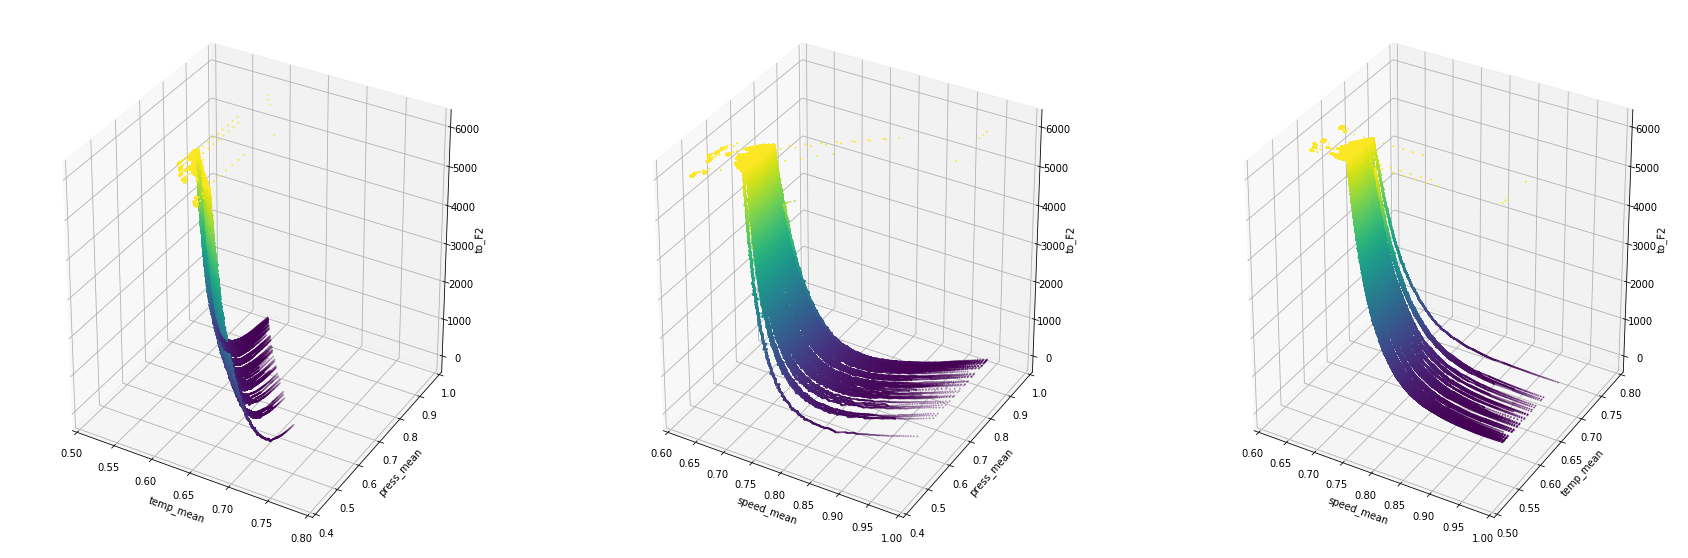

CPU times: user 34.6 s, sys: 617 ms, total: 35.2 s
Wall time: 34.6 s


In [47]:
%%time
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(131, projection='3d')
for i in mac_panne[1]:
    z = parc_moy[i]["to_F2"]
    ax.scatter(xs=parc_moy[i]["temp_mean"], ys=parc_moy[i]["press_mean"], zs=z, s=1, c=z)
ax.set_xlim(.5, .8)
ax.set_ylim(.4, 1)
ax.set_xlabel('temp_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F2')

ax = fig.add_subplot(132, projection='3d')
for i in mac_panne[1]:
    z = parc_moy[i]["to_F2"]
    ax.scatter(xs=parc_moy[i]["speed_mean"], ys=parc_moy[i]["press_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 1)
ax.set_ylim(.4, 1)
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F2')

ax = fig.add_subplot(133, projection='3d')
for i in mac_panne[1]:
    z = parc_moy[i]["to_F2"]
    ax.scatter(xs=parc_moy[i]["speed_mean"], ys=parc_moy[i]["temp_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 1)
ax.set_ylim(.5, .8)
ax.set_xlabel('speed_mean')
ax.set_ylabel('temp_mean')
ax.set_zlabel('to_F2')
plt.show()

# Concaténation des données, écriture dans un fichier

On concatène les données du parc (avec les moyennes glissantes, soit `parc_moy`) dans un DataFrame `donnees`. En plus du DataFrame `donnees`, il est utile de conserver la liste de deux ensembles d'entiers donnant les machines ayant connu des pannes de type donné (`mac_panne`). Quant à `n_machines`, on le retrouve facilement par `n_machines = len(donnees["machineID"].unique())`, de même que `maxi` se retrouve par `maxi = donnees["to_F1"].max(axis=0)`.

La partie ML est faite dans le second notebook `maintenance_2_modeles.ipynb`.

In [48]:
%%time
#avec ré-indexation pour avoir un index standard
donnees = pd.concat(parc_moy).reset_index()

CPU times: user 421 ms, sys: 109 ms, total: 530 ms
Wall time: 529 ms


In [49]:
%%time
# Ecriture dans un fichier .parquet
donnees.to_parquet("donnees.parquet")

CPU times: user 1.28 s, sys: 356 ms, total: 1.64 s
Wall time: 1.65 s


In [50]:
joblib.dump(mac_panne, "mac_panne.pkl")

['mac_panne.pkl']